Preamble

In [171]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from astropy.table import Table

Plotting functions

In [167]:
def scatter_hist(ax, x, y, xlim=None, ylim=None, log_norm=True, cmap='gray',
                 cmin=10, vmin=None, vmax=None, nbins=50, color='k'):
    """
    Generate a scatter plot and overlayed 2D histogram for dense data.

    Parameters
    ----------
    ax : matplotlib.axis.Axes
        Axes object on which to plot the data.
    x : array-like
        Horizontal coordinates of the data points.
    y : array-like
        Vertical coordinates of the data points.
    xlim : float, optional
        Bounds for x-axis. The default is None.
    ylim : float, optional
        Bounds for y-axis. The default is None.
    log_norm : bool, optional
        Shade the 2D histogram on a logarithmic scale. The default is True.
    cmap : str, optional
        Colormap for 2D histogram. The default is'gray'.
    cmin : int, optional
        Minimum counts per bin; any number below this will show individual points.
        The default is 10.
    vmin : float or None, optional
        Value to map to minimum of histogram normalization. The default is None.
    vmax : float or None, optional
        Value to map to maximum of histogram normalization. The default is None.
    nbins : int or tuple of ints, optional
        Number of histogram bins. If a tuple, presumed to be (xbins, ybins).
        The default is 50.
    color : str, optional
        Color of individual points. The default is 'k'.

    Returns
    -------
    matplotlib.axis.Axes

    """
    # Set automatic plot bounds
    if not xlim:
        xlim = (np.min(x), np.max(x))
    if not ylim:
        ylim = (np.min(y), np.max(y))
    # Set bin edges
    if type(nbins) == 'tuple':
        xbins, ybins = nbins
    else:
        xbins = ybins = nbins
    xbins = np.linspace(xlim[0], xlim[1], num=xbins, endpoint=True)
    ybins = np.linspace(ylim[0], ylim[1], num=ybins, endpoint=True)
    # Histogram normalization
    if log_norm:
        norm = colors.LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        
    ax.scatter(x, y, c=color, s=0.5)
    ax.hist2d(x, y, bins=[xbins, ybins], cmap=cmap, norm=norm, cmin=cmin)
        
    dx = xbins[1] - xbins[0]
    dy = ybins[1] - ybins[0]
    ax.set_xlim((xlim[0] - 2*dx, xlim[1] + 2*dx))
    ax.set_ylim((ylim[0] - 2*dy, ylim[1] + 2*dy))
    
    return ax

Import ASPCAP allStar file

In [203]:
aspcap_path = Path("data/allStarLite-dr17-synspec.fits")
# Import APOGEE allStar data
aspcap_table = Table.read(aspcap_path, format='fits', hdu=1)
# Separate paramflags into individual columns
for i in range(len(aspcap_table['PARAMFLAG'][0])):
    aspcap_table['PARAMFLAG' + str(i)] = aspcap_table['PARAMFLAG'][:,i]
# Filter out multidimensional columns
cols = [name for name in aspcap_table.colnames if len(aspcap_table[name].shape) <= 1]

def decode(df):
    """
    Decode DataFrame with byte strings into ordinary strings.
    """
    str_df = df.select_dtypes([object])
    str_df = str_df.stack().str.decode('utf-8').unstack()
    for col in str_df:
        df[col] = str_df[col]
    return df

aspcap_df = decode(aspcap_table[cols].to_pandas())
# Relace NaN
aspcap_df.replace(99.999, np.nan, inplace=True)
# Replace '' with 'none' in columns of type 'object'
aspcap_df.replace('', 'none', inplace=True)
# Remove VESTA
aspcap_df.drop(0, inplace=True)
# Weed out bad flags
fatal_flags = (2**23) # STAR_BAD
aspcap_df = aspcap_df[aspcap_df["ASPCAPFLAG"] & fatal_flags == 0]
aspcap_df.reset_index(inplace=True)
# Copy 2Mass ID column without "2M" prefix
aspcap_df["XMATCH_ID"] = [id[2:] for id in aspcap_df.APOGEE_ID.tolist()]
aspcap_df["XMATCH_ID"].to_csv("data/apogee_tmass_ids.csv", index=False, header=False)

Import and combine Gaia DR3

In [148]:
xmatch = pd.read_csv("data/apogee_xmatch.csv")
xmatch.set_index("original_ext_source_id", inplace=True)
xmatch

,source_id,ra,dec,teff_gspphot,logg_gspphot,mh_gspphot
original_ext_source_id,,,,,,
00000002+7417074,538028216707715712,0.000205,74.285436,3739.0503,0.7531,0.3802
00000019-1924498,2413929812587459072,0.000970,-19.413922,NaN,NaN,NaN
00000032+5737103,422596679964513792,0.001332,57.619507,6385.4890,3.7911,-0.5524
00000032+5737103,422596679964513792,0.001332,57.619507,6385.4890,3.7911,-0.5524
00000035-7323394,4689447878791422208,0.001481,-73.394323,4877.1636,3.4546,-0.0319
...,...,...,...,...,...,...
23595886-2009435,2341765776376373376,359.995295,-20.162166,5500.4463,4.1270,-0.1269
23595886+5726058,1998097371124974720,359.995268,57.434918,5213.7530,2.9823,-0.0155
23595921+5609479,1994741318040223232,359.996716,56.163345,NaN,NaN,NaN


In [150]:
alldata = aspcap_df.join(xmatch, on="XMATCH_ID", rsuffix="_GAIA")
alldata

,index,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,...,PARAMFLAG6,PARAMFLAG7,PARAMFLAG8,XMATCH_ID,source_id,ra,dec,teff_gspphot,logg_gspphot,mh_gspphot
0,1,2M00000002+7417074,apo25m,120+12,none,0.000103,74.285408,119.401807,11.767414,8.597,...,0,0,0,00000002+7417074,5.380282e+17,0.000205,74.285436,3739.0503,0.7531,0.3802
1,2,2M00000019-1924498,apo25m,060-75,none,0.000832,-19.413851,63.394122,-75.906397,11.074,...,0,0,0,00000019-1924498,2.413930e+18,0.000970,-19.413922,NaN,NaN,NaN
2,3,2M00000032+5737103,apo25m,116-04,none,0.001335,57.619530,116.065371,-4.564768,10.905,...,0,0,0,00000032+5737103,4.225967e+17,0.001332,57.619507,6385.4890,3.7911,-0.5524
2,3,2M00000032+5737103,apo25m,116-04,none,0.001335,57.619530,116.065371,-4.564768,10.905,...,0,0,0,00000032+5737103,4.225967e+17,0.001332,57.619507,6385.4890,3.7911,-0.5524
3,4,2M00000032+5737103,apo25m,N7789,none,0.001335,57.619530,116.065371,-4.564768,10.905,...,0,0,0,00000032+5737103,4.225967e+17,0.001332,57.619507,6385.4890,3.7911,-0.5524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733895,733896,2M23595886-2009435,apo25m,060-75,none,359.995258,-20.162107,60.806239,-76.324013,11.788,...,0,0,0,23595886-2009435,2.341766e+18,359.995295,-20.162166,5500.4463,4.1270,-0.1269
733896,733897,2M23595886+5726058,apo25m,116-04,none,359.995265,57.434956,116.025359,-4.745011,11.466,...,0,0,0,23595886+5726058,1.998097e+18,359.995268,57.434918,5213.7530,2.9823,-0.0155
733897,733898,2M23595921+5609479,apo25m,NGC7789_MGA,none,359.996744,56.163330,115.771964,-5.991363,11.985,...,0,0,0,23595921+5609479,1.994741e+18,359.996716,56.163345,NaN,NaN,NaN
733898,733899,2M23595949-7342592,lco25m,SMC12,none,359.997887,-73.716454,307.821174,-42.919934,15.924,...,32,0,0,23595949-7342592,6.379915e+18,359.997823,-73.716478,5042.1333,4.4005,-0.1207


In [177]:
alldata[pd.isna(alldata['source_id'])]

,index,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,...,PARAMFLAG6,PARAMFLAG7,PARAMFLAG8,XMATCH_ID,source_id,ra,dec,teff_gspphot,logg_gspphot,mh_gspphot
949,950,2M00035232+6452114,apo25m,117+01,none,0.968033,64.869858,117.907005,2.463335,8.387,...,0,0,0,00035232+6452114,NaN,NaN,NaN,NaN,NaN,NaN
1112,1113,2M00043457+1623294,apo25m,105-45,none,1.144051,16.391527,106.935236,-45.019637,11.752,...,64,0,0,00043457+1623294,NaN,NaN,NaN,NaN,NaN,NaN
1113,1114,2M00043457+1623294,apo25m,107-46_MGA,none,1.144051,16.391527,106.935236,-45.019637,11.752,...,96,0,0,00043457+1623294,NaN,NaN,NaN,NaN,NaN,NaN
1838,1839,2M00074087+7116518,apo25m,120+08,none,1.920315,71.281059,119.399597,8.710170,13.512,...,32,32,0,00074087+7116518,NaN,NaN,NaN,NaN,NaN,NaN
2087,2088,2M00083751+1353031,apo25m,107-46_MGA,none,2.156329,13.884213,107.395514,-47.691798,9.270,...,0,0,0,00083751+1353031,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732708,732709,2M23551905+6218278,apo25m,116+00,none,358.829407,62.307728,116.463029,0.143058,12.212,...,0,0,0,23551905+6218278,NaN,NaN,NaN,NaN,NaN,NaN
733118,733119,2M23564982+5657593,apo25m,N7789,none,359.207615,56.966480,115.509861,-5.116134,10.759,...,32,256,0,23564982+5657593,NaN,NaN,NaN,NaN,NaN,NaN
733138,733139,2M23565481+7330355,apo25m,120+12,none,359.228382,73.509888,119.023656,11.053397,12.530,...,0,0,0,23565481+7330355,NaN,NaN,NaN,NaN,NaN,NaN
733498,733499,2M23581374+6110358,apo25m,116+00,none,359.557252,61.176636,116.562068,-1.035187,11.705,...,66,288,0,23581374+6110358,NaN,NaN,NaN,NaN,NaN,NaN


In [160]:
rg = alldata[(alldata["TEFF"] < 6000) & (alldata["LOGG"] < 4)]

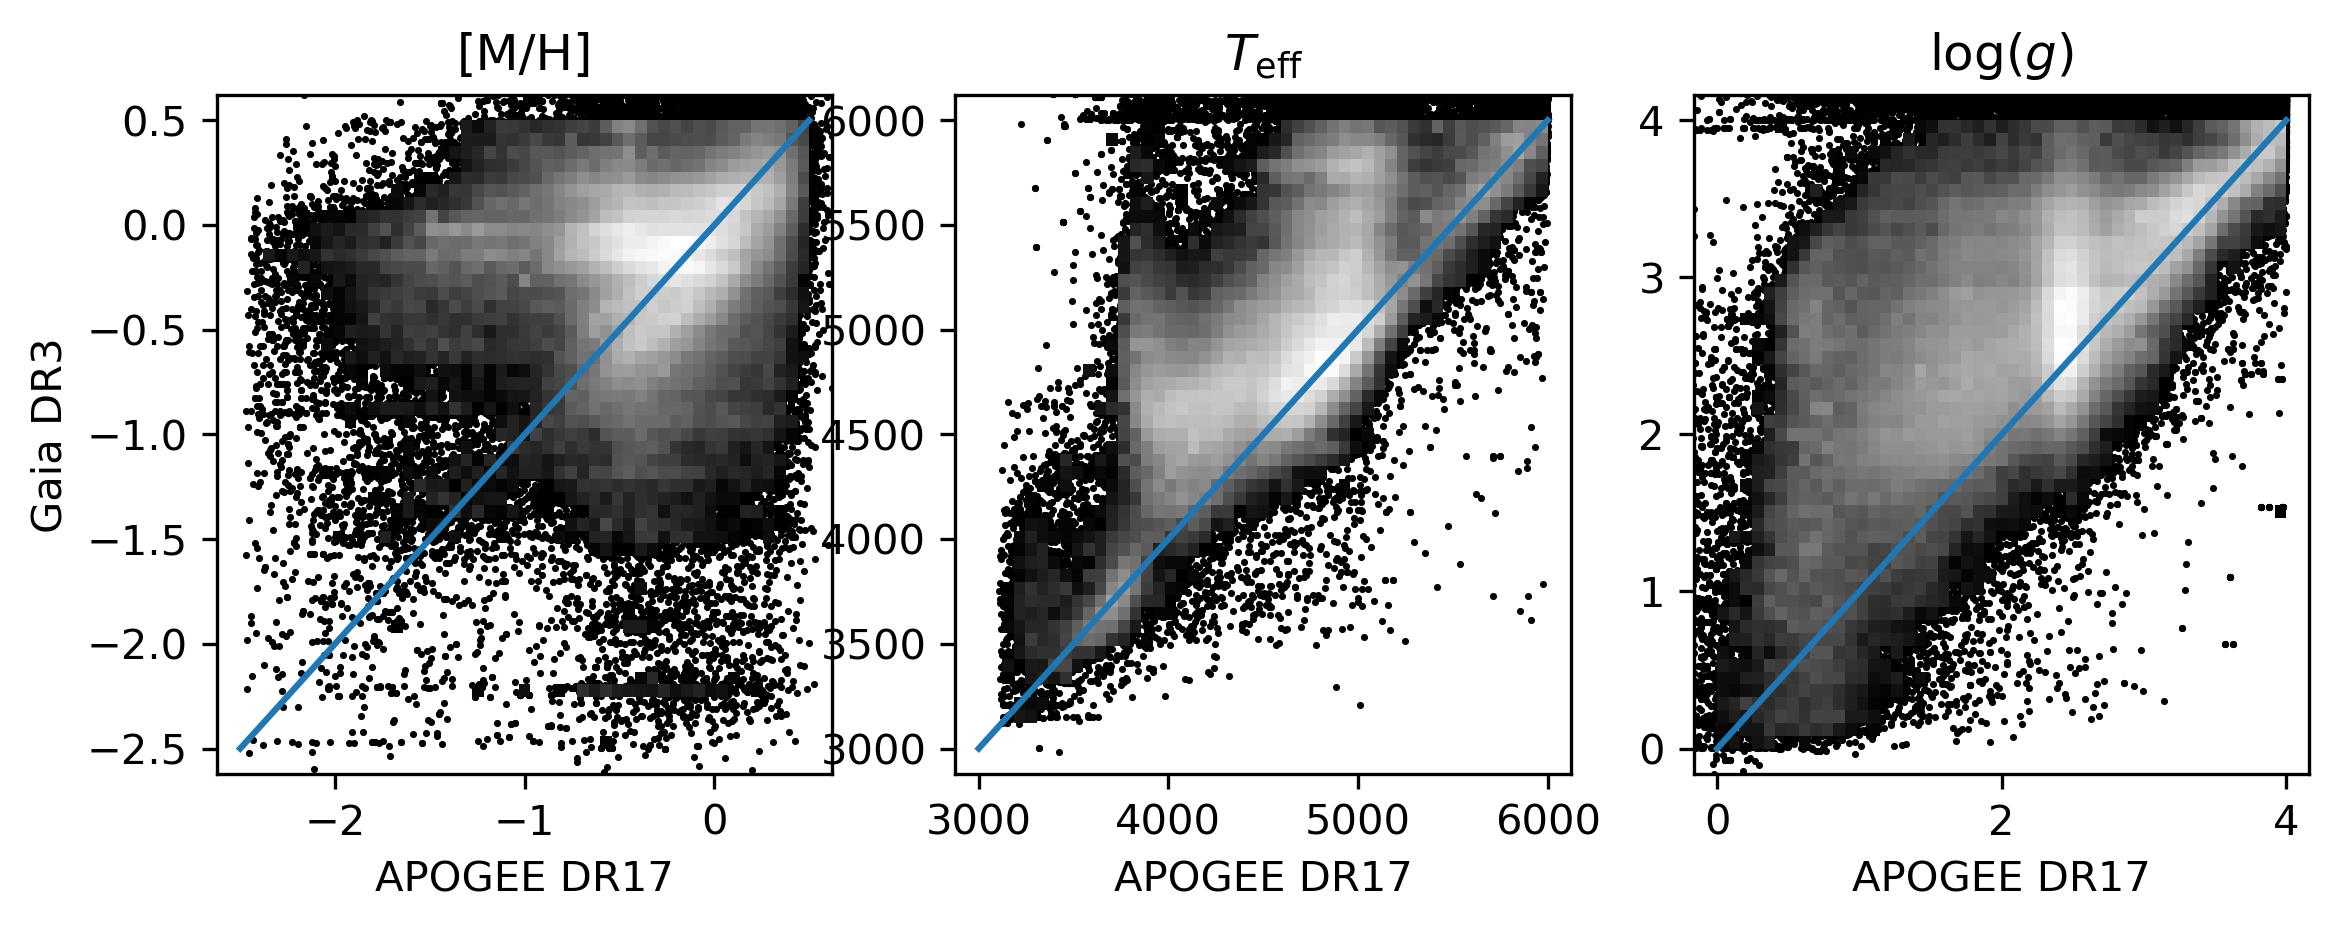

In [174]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), dpi=300)
scatter_hist(axs[0], rg["M_H"], rg["mh_gspphot"], xlim=(-2.5, 0.5), ylim=(-2.5, 0.5))
# axs[0].scatter(rg["M_H"], rg["mh_gspphot"], s=0.1, c='k')
axs[0].plot([-2.5, 0.5], [-2.5, 0.5])
axs[0].set_xlabel("APOGEE DR17")
axs[0].set_ylabel("Gaia DR3")
axs[0].set_title("[M/H]")
scatter_hist(axs[1], rg["TEFF"], rg["teff_gspphot"], xlim=(3000, 6000), ylim=(3000, 6000))
# axs[1].scatter(rg["TEFF"], rg["teff_gspphot"], s=0.1, c=rg["M_H"])
axs[1].plot([3000, 6000], [3000, 6000])
# axs[1].set_ylim((2900, 6100))
axs[1].set_xlabel("APOGEE DR17")
axs[1].set_title(r"$T_{\rm{eff}}$")
scatter_hist(axs[2], rg["LOGG"], rg["logg_gspphot"], xlim=(0, 4), ylim=(0, 4))
# axs[2].scatter(rg["LOGG"], rg["logg_gspphot"], s=0.1, c=rg["M_H"])
axs[2].plot([0, 4], [0, 4])
# axs[2].set_ylim((-1, 5))
axs[2].set_xlabel("APOGEE DR17")
axs[2].set_title(r"$\log(g)$")
plt.show()